In [10]:
# import required modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cooltools
import bioframe
import cooler

from cooltools import eigdecomp
from HMMC.HMMC import get_segmentation


In [11]:
# todo: update this with storage location
# specify cooler and fasta storage locations
# cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
# cooler_file = '/pollard/data/wynton/consortia/4DN/krietenstein2020/H1-hESC/4DNFI9GMP2J8.mcool'
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/IMR90/4DNFIJTOIGOI.mcool'
fasta_file='/pollard/data/vertebrate_genomes/human/hg38/hg38/hg38.fa'

In [12]:
# load cooler, obtain bin table
resolution = 50000
c = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))
chromsizes = c.chromsizes      
bins = c.bins()[:]

In [13]:
# generate binned dataframe of GC content
fasta_records = bioframe.load_fasta(fasta_file)
gc_table = bioframe.genomeops.frac_gc(bins, fasta_records)

In [14]:
# specify regions as autosomes, obtain cis eigenvectors
regions = [(chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames if (chrom.replace('chr','')).isdigit() ]
cis_val, cis_eig = eigdecomp.cooler_cis_eig(
                c, 
                gc_table,
                regions,
                n_eigs=3, 
                balance=True,
                ignore_diags = 2, clip_percentile=99)
cis_eig = cis_eig.iloc[ np.array([i.isdigit() for i in cis_eig.chrom.str.replace('chr','').values])]

In [15]:
# get segmentation using HMMC
hmm_track = get_segmentation(cis_eig, state_list= ["binary", "HMM2","HMM3", "HMM3P"])

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


Text(0.5, 0, 'position, bins')

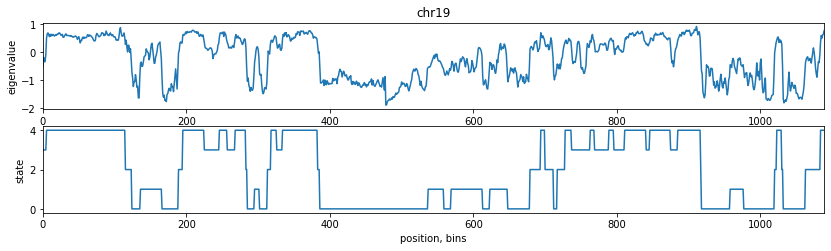

In [16]:
# visualize eigenvector and HMM3P segmentation for chromosome 19
# HMM3P_nums_to_names =  {0:'B', 1:'M_{bb}', 2:'M', 3:'M_{aa}', 4:'A'}
# HMM2_nums_to_names  =  {0:'B', 1:'A'}

fig = plt.figure(figsize=(14, 3.5))

ax1 = plt.subplot('211')
chrom = 'chr19'
mask = (~hmm_track['E1'].isna()) & (hmm_track.chrom == chrom)
y1 = hmm_track[mask]['E1'].values
ax1.plot(y1)
ax1.margins(x=0)
ax1.set_ylabel('eigenvalue')
plt.title(chrom)

# plt.figure(figsize=(14, 1.5))
ax2 = plt.subplot('212')
y2 = hmm_track[mask]['HMM3P'].values 
ax2.plot(y2)
ax2.set_ylabel('state')
ax2.margins(x=0)

plt.xlabel('position, bins')


In [17]:
hmm_track

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P
0,chr1,0,50000,0.011192,0.001988,0.037799,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,50000,100000,0.154982,0.026789,0.138755,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,100000,150000,0.046705,0.007207,0.071968,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,150000,200000,0.087255,0.012972,0.096555,NaN,0.486340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,200000,250000,0.011123,0.000895,0.025357,NaN,0.480564,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57504,chr22,50600000,50650000,0.994317,1.937600,0.961661,0.006870,0.528300,0.317024,0.534714,0.106006,1.0,1.0,1.0,2.0
57505,chr22,50650000,50700000,0.848444,1.576094,0.867323,0.008486,0.514480,0.164220,0.746097,0.388340,1.0,1.0,1.0,2.0
57506,chr22,50700000,50750000,0.972175,1.731377,0.909046,0.007541,0.566380,0.234157,0.930383,0.474490,1.0,1.0,1.0,2.0
57507,chr22,50750000,50800000,0.444639,0.697798,0.577105,NaN,0.441900,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# hmm_track.to_csv('../annotations/GM12878_hg38_50kb.tsv', sep='\t', index=False)
# hmm_track.to_csv('../annotations/H1-hESC_hg38_50kb.tsv', sep='\t', index=False)
hmm_track.to_csv('../annotations/IMR90_hg38_50kb.tsv', sep='\t', index=False)